# Twitter & Bitcoin


### Tian Zhou


# 1. Twitter Data Set


## 1.1 Data Cleaning

### Raw Data:

https://www.kaggle.com/datasets/alaix14/bitcoin-tweets-20160101-to-20190329
https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

### Initial Cleaning & Translating by Adam:

In [1]:
import pandas as pd

In [2]:
#Tweets dataset
tweets_path = "~/Desktop/SDA25_Group11/data/tweets_2018_2019.csv"

tweets = pd.read_csv(tweets_path)

In [3]:
#Bitcoin dataset
btc_path = "~/Desktop/SDA25_Group11/data/btc_2018_2019.csv"

btc = pd.read_csv(btc_path)

### Analysis Cleaning:

In [67]:
#first print initial dataset
tweets_path = "../data/tweets_2018_2019.csv"
tweets = pd.read_csv(tweets_path)

tweets["timestamp"] = pd.to_datetime(tweets["timestamp"], errors="coerce")#convert timestamp

tweets = tweets[tweets["timestamp"].notnull()]#drop invalid rows
tweets = tweets[tweets["text"].notnull()]
tweets = tweets[tweets["text"].str.strip() != ""]#remove null text

tweets = tweets[~tweets["text"].str.startswith("RT")]#remove retweets-repeating tweets*


tweets["date"] = tweets["timestamp"].dt.date
tweets = tweets[["date", "text"]]

tweets = tweets.reset_index(drop=True)

display(tweets.head())


,date,text
0,2018-09-11,I didnt tether at $7300 #iamspartacus\n$btc $e...
1,2018-12-29,The first lab made diamond happened in 1955 &a...
2,2018-04-17,Great talk and discussions about Bitcoin vs. E...
3,2018-02-08,"When things are down, remember it's never as b..."
4,2018-06-09,Wow! We reached 25K followers just within 4 we...


## 1.2 Sentiment Scoring

### Preprocess：

In [68]:
!pip install nltk

In [69]:
import nltk
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")

def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()
    text = re.sub(r"http\S+", "", text)          
    text = re.sub(r"@\w+", "", text)             
    text = re.sub(r"#", " ", text)    
    text = re.sub(r"[^a-zA-Z0-9\s\$\%\.]", " ", text)  
    text = re.sub(r"\s+", " ", text).strip()     
    return text


tweets["clean_text"] = tweets["text"].apply(preprocess_text)

print("Example of cleaned text:")
display(tweets[["text", "clean_text"]].head())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhoutian/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Example of cleaned text:


,text,clean_text
0,I didnt tether at $7300 #iamspartacus\n$btc $e...,i didnt tether at $7300 iamspartacus $btc $eth...
1,The first lab made diamond happened in 1955 &a...,the first lab made diamond happened in 1955 am...
2,Great talk and discussions about Bitcoin vs. E...,great talk and discussions about bitcoin vs. e...
3,"When things are down, remember it's never as b...",when things are down remember it s never as ba...
4,Wow! We reached 25K followers just within 4 we...,wow we reached 25k followers just within 4 wee...


### VADER & 2018–2019 crypto slang lexicon

In [71]:
analyzer = SentimentIntensityAnalyzer()

crypto_slang_2018_2019 = {
    "moon": 3.0,
    "mooning": 3.0,
    "pump": 2.8,
    "pumping": 2.8,
    "bull": 2.3,
    "bullish": 3.0,
    "bullrun": 3.0,
    "breakout": 2.0,
    "ath": 2.4,
    "green_candle": 2.2,
    "hodl": 2.0,
    "hodling": 2.0,
    "lambo": 2.8,
    "buy_the_dip": 2.0,

    "crash": -3.8,
    "dump": -3.2,
    "dumping": -3.2,
    "rekt": -3.5,
    "liquidated": -3.5,
    "bearish": -3.0,
    "selloff": -3.0,
    "bloodbath": -3.5,
    "panic": -2.5,
    "fud": -2.5,
    "scam": -3.5,
    "exit_scam": -3.5,
    "bagholder": -2.2,
    "deadcat": -3.0,
    "capitulation": -3.0
}

#update
analyzer.lexicon.update(crypto_slang_2018_2019)


In [72]:
def compute_sentiment(text):
    return analyzer.polarity_scores(text)["compound"]

tweets["sentiment"] = tweets["clean_text"].apply(compute_sentiment)

print("Sample sentiment scores:")
display(tweets[["clean_text", "sentiment"]].head())


Sample sentiment scores:


,clean_text,sentiment
0,i didnt tether at $7300 iamspartacus $btc $eth...,0.0000
1,the first lab made diamond happened in 1955 am...,0.7678
2,great talk and discussions about bitcoin vs. e...,0.7650
3,when things are down remember it s never as ba...,-0.4497
4,wow we reached 25k followers just within 4 wee...,0.9217


## 1.3 Daily Aggregasion

In [73]:
daily_sentiment = (
    tweets.groupby("date")["sentiment"]
    .mean()
    .reset_index()
    .rename(columns={"sentiment": "daily_sentiment"})
)

display(daily_sentiment.head())

daily_sentiment.to_csv("../data/daily_sentiment.csv", index=False)


,date,daily_sentiment
0,2018-01-01,0.076574
1,2018-01-02,0.059282
2,2018-01-03,0.056303
3,2018-01-04,0.076401
4,2018-01-05,0.065748


# 2. Bitcoin

## 2.1 Preprocess

In [74]:
import pandas as pd

btc_path = "../data/btc_2018_2019.csv"
btc = pd.read_csv(btc_path)

#parse timestamp correctly
btc["timestamp"] = pd.to_datetime(btc["timestamp"], errors="coerce")

#remove invalid timestamps
btc = btc[btc["timestamp"].notna()]

btc["date"] = btc["timestamp"].dt.date

#compute daily closing price
daily_price = (
    btc.groupby("date")["close"]
       .last()
       .reset_index()
)

# ompute daily return
daily_price["return"] = daily_price["close"].pct_change()

display(daily_price.head())


,date,close,return
0,2018-01-01,13189.36,NaN
1,2018-01-02,14596.11,0.106658
2,2018-01-03,14834.30,0.016319
3,2018-01-04,14780.40,-0.003633
4,2018-01-05,16367.42,0.107373


## 2.2 Merge 

In [75]:
# Load daily sentiment
sent = pd.read_csv("../data/daily_sentiment.csv")
sent["date"] = pd.to_datetime(sent["date"]).dt.date

# Load BTC daily price + return (daily_price comes from previous step)
btc = daily_price.copy()
btc["date"] = pd.to_datetime(btc["date"]).dt.date

# Merge on date
merged = pd.merge(sent, btc, on="date", how="inner")

# Use sentiment(t) to predict return(t+1)
merged["sentiment_lag1"] = merged["daily_sentiment"].shift(1)

# Final clean dataset for analysis
merged = merged.dropna(subset=["sentiment_lag1", "return"])

display(merged.head())


,date,daily_sentiment,close,return,sentiment_lag1
1,2018-01-02,0.059282,14596.11,0.106658,0.076574
2,2018-01-03,0.056303,14834.30,0.016319,0.059282
3,2018-01-04,0.076401,14780.40,-0.003633,0.056303
4,2018-01-05,0.065748,16367.42,0.107373,0.076401
5,2018-01-06,0.072340,16772.83,0.024769,0.065748


### Scatter Plot: sentiment_lag1 vs return

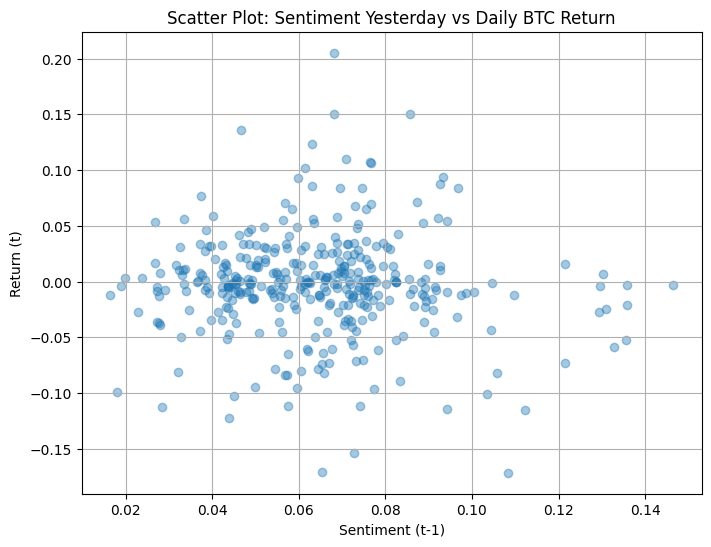

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(merged["sentiment_lag1"], merged["return"], alpha=0.4)
plt.xlabel("Sentiment (t-1)")
plt.ylabel("Return (t)")
plt.title("Scatter Plot: Sentiment Yesterday vs Daily BTC Return")
plt.grid(True)
plt.show()


### Time Series Plot

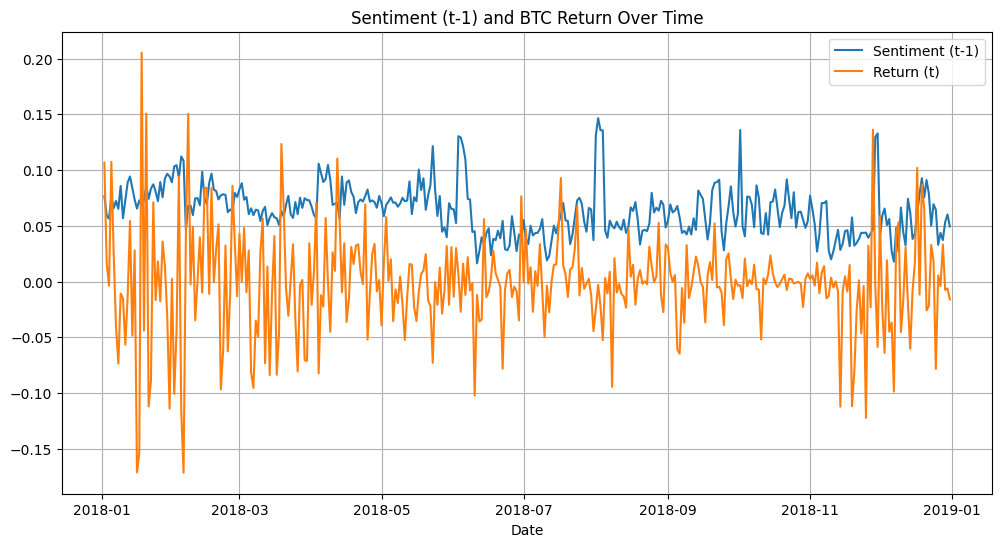

In [77]:
plt.figure(figsize=(12,6))
plt.plot(merged["date"], merged["sentiment_lag1"], label="Sentiment (t-1)")
plt.plot(merged["date"], merged["return"], label="Return (t)")
plt.legend()
plt.title("Sentiment (t-1) and BTC Return Over Time")
plt.xlabel("Date")
plt.grid(True)
plt.show()


## 2.3 Correlation


In [78]:
corr_value = merged["sentiment_lag1"].corr(merged["return"])
print("Pearson Correlation between sentiment_lag1 and return:", corr_value)


Pearson Correlation between sentiment_lag1 and return: -0.0565834522323994


### Rolling Correlation

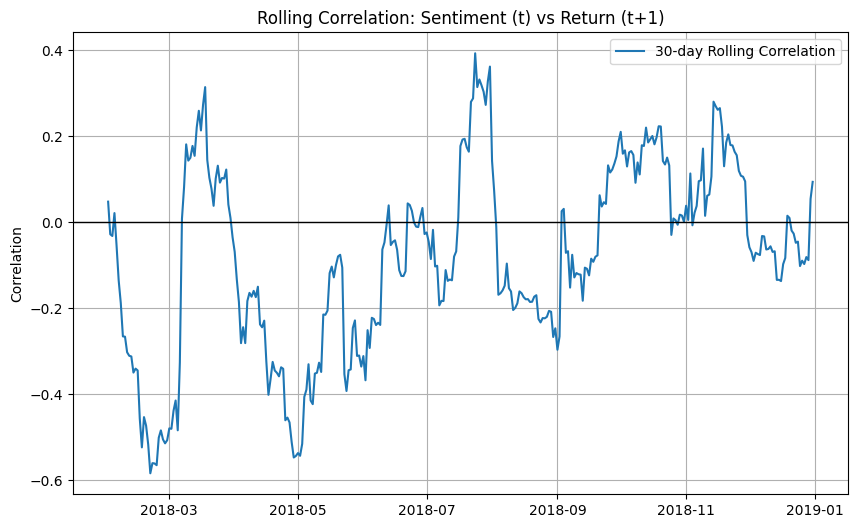

In [80]:
merged["rolling_corr"] = merged["sentiment_lag1"].rolling(30).corr(merged["return"])

plt.figure(figsize=(10,6))
plt.plot(merged["date"], merged["rolling_corr"], label="30-day Rolling Correlation")
plt.axhline(0, color="black", linewidth=1)
plt.title("Rolling Correlation: Sentiment (t) vs Return (t+1)")
plt.ylabel("Correlation")
plt.grid(True)
plt.legend()
plt.show()


## 2.4 Regression

In [30]:
!pip install statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 32.2 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 29.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [statsmodels] [statsmodels]


In [81]:
import statsmodels.api as sm

# Use sentiment_lag1 to predict next-day return
df = merged.dropna(subset=["sentiment_lag1", "return"])

X = df[["sentiment_lag1"]]           # predictor
y = df["return"]                     # target variable

X = sm.add_constant(X)               # adds intercept
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.163
Date:                Mon, 08 Dec 2025   Prob (F-statistic):              0.282
Time:                        08:54:02   Log-Likelihood:                 606.69
No. Observations:                 364   AIC:                            -1209.
Df Residuals:                     362   BIC:                            -1202.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0051      0.007      0.

### Scatter + Regression Line

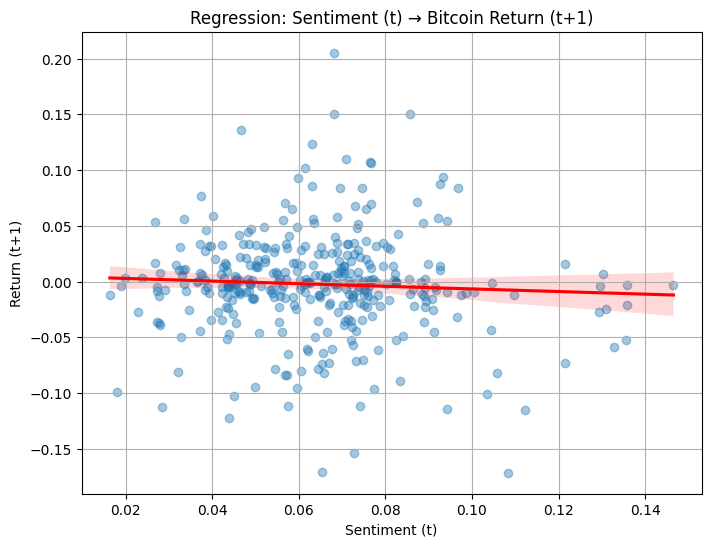

In [82]:
plt.figure(figsize=(8,6))
sns.regplot(x=df["sentiment_lag1"], y=df["return"], scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.xlabel("Sentiment (t)")
plt.ylabel("Return (t+1)")
plt.title("Regression: Sentiment (t) → Bitcoin Return (t+1)")
plt.grid(True)
plt.show()
